In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature

In [3]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, 'is_train', 'date']

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train 
               if not path.count('V') 
               and not path.count('raw__C') 
#                if path.cout('Fraud') 
#                or path.count('tionID') 
#                or path.count('C1')
#                or path.count('C13')
#                or path.count('V232')
#                or path.count('addr1')
]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test 
               if not path.count('V') 
               and not path.count('raw__C') 
#                if path.cout('Fraud') 
#                or path.count('tionID') 
#                or path.count('C1')
#                or path.count('C13')
#                or path.count('V232')
#                or path.count('addr1')
]
paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

In [4]:
df_train = reduce_mem_usage( parallel_load_data(paths_train) )
df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

Memory usage of dataframe is 220.77 MB
Memory usage after optimization is: 218.52 MB
Decreased by 1.0%
Memory usage of dataframe is 407.35 MB
Memory usage after optimization is: 459.54 MB
Decreased by -12.8%


  1%|          | 1/166 [00:00<00:16,  9.84it/s]

* Check Unique Feature.


100%|██████████| 166/166 [00:01<00:00, 83.55it/s] 


All Features have info.
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.934898
[400]	valid_0's auc: 0.9421
[600]	valid_0's auc: 0.945263
[800]	valid_0's auc: 0.947297
[1000]	valid_0's auc: 0.948234
Early stopping, best iteration is:
[1057]	valid_0's auc: 0.948696
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.926623
[400]	valid_0's auc: 0.934932
[600]	valid_0's auc: 0.938253
Early stopping, best iteration is:
[711]	valid_0's auc: 0.940634
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.929529
[400]	valid_0's auc: 0.937576
[600]	valid_0's auc: 0.942475
[800]	valid_0's auc: 0.944795
Early stopping, best iteration is:
[871]	valid_0's auc: 0.945136
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.918728
[400]	valid_0's auc: 0.929469
[600]	valid_0's auc: 0.933
Early stopping, best iteration is:
[639]	valid_0's auc: 0.934374
Training until valida

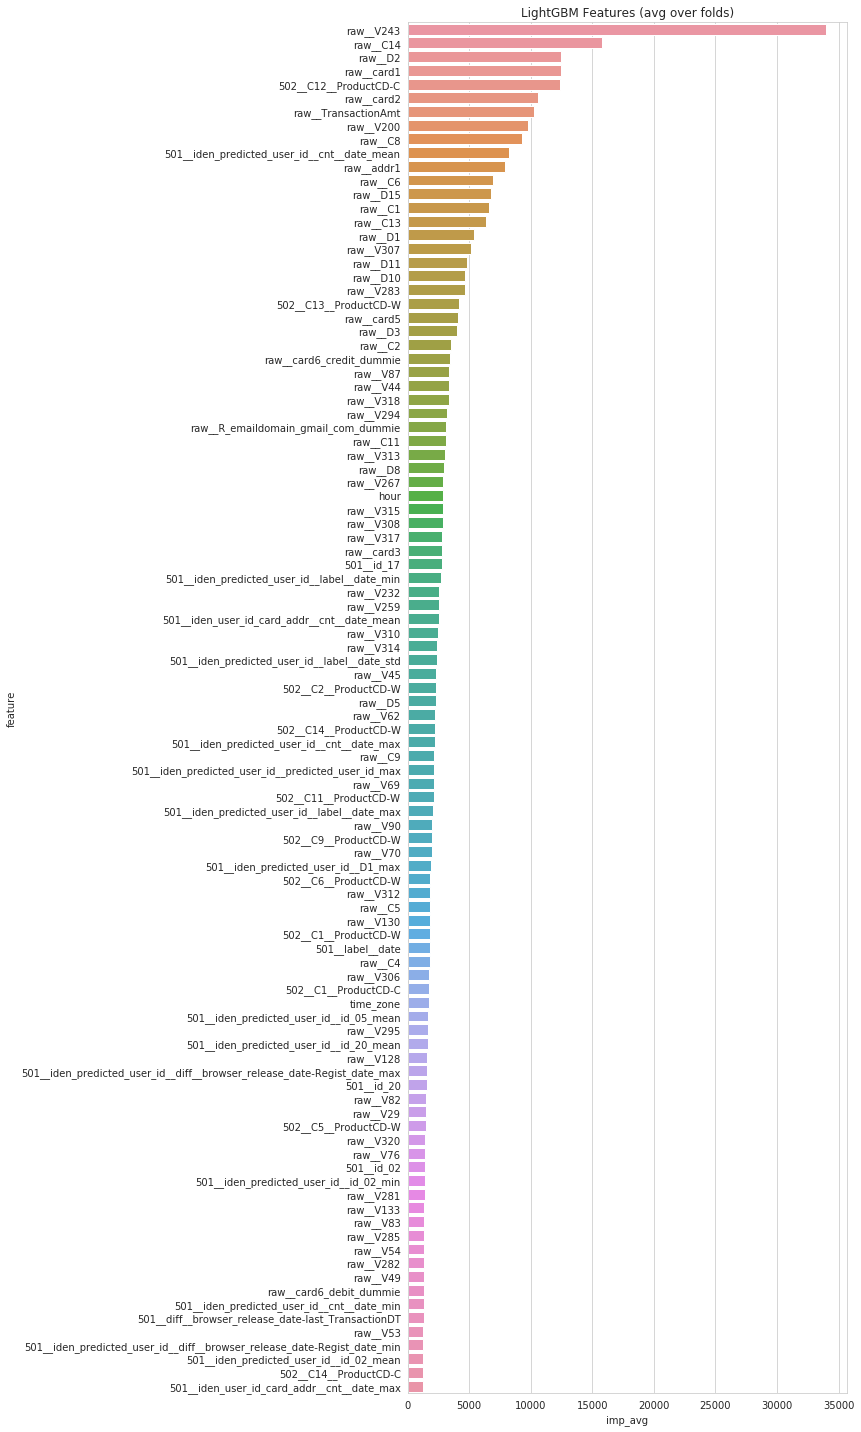

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.910764
[400]	valid_0's auc: 0.922149
[600]	valid_0's auc: 0.927083
[800]	valid_0's auc: 0.930043
[1000]	valid_0's auc: 0.932248
[1200]	valid_0's auc: 0.933868
[1400]	valid_0's auc: 0.93525
[1600]	valid_0's auc: 0.936231
[1800]	valid_0's auc: 0.937118
[2000]	valid_0's auc: 0.937845
[2200]	valid_0's auc: 0.938422
[2400]	valid_0's auc: 0.939082
[2600]	valid_0's auc: 0.939644
[2800]	valid_0's auc: 0.940031
[3000]	valid_0's auc: 0.940392
[3200]	valid_0's auc: 0.940774
[3400]	valid_0's auc: 0.941054
Did not meet early stopping. Best iteration is:
[3498]	valid_0's auc: 0.941257
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.912768
[400]	valid_0's auc: 0.92318
[600]	valid_0's auc: 0.928137
[800]	valid_0's auc: 0.931113
[1000]	valid_0's auc: 0.933012
[1200]	valid_0's auc: 0.934642
[1400]	valid_0's auc: 0.935683
[1600]	valid_0's auc: 0.936641
[1800]	valid_0's auc: 0.937465
[

MemoryError: 

In [5]:
list_feim = []
for i in range(1, 2, 1):
    
#     valid_paths_train = paths_train_feature[i*800:(i+1)*800]
#     valid_paths_test  = paths_test_feature[i*800:(i+1)*800]
    valid_paths_train = paths_train_feature
    valid_paths_test  = paths_test_feature
    
    #========================================================================
    # pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
    #========================================================================
    remove_paths = []
    for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
        if os.path.exists(trn_path) and os.path.exists(tes_path):
            pass
        else:
            remove_paths.append(trn_path)
            remove_paths.append(tes_path)
    for path in remove_paths:
        if path.count('train'):
            valid_paths_train.remove(path)
            print(f'remove {path}')
        elif path.count('test'):
            valid_paths_test.remove(path)
            print(f'remove {path}')
    
#     df_feat_train = reduce_mem_usage( parallel_load_data(valid_paths_train) )
#     df_feat_test  = reduce_mem_usage( parallel_load_data(valid_paths_test) )
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
    
    #========================================================================
    # Train Test で片方に存在しないFeatureを除外
    #========================================================================
    diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))
    for col in list(set(diff_cols)):
        if col.count('raw'):
            from_dir = 'raw_use'
            to_dir = 'raw_trush'
        else:
            from_dir = 'org_use'
            to_dir = 'org_trush'
        move_feature([col], from_dir, to_dir)
    tmp_train.drop(diff_cols, axis=1, inplace=True)
    
    # same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
    same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
    model_type = "lgb"
    params = {
        'n_jobs': 60,
        'seed': 1208,
        'n_splits': 5,
        'metric': 'auc',
        'model_type': model_type,
        'objective': 'binary',
        'fold': ['stratified', 'group'][1],
        'num_leaves': 2**6-1,
        'max_depth': 8,
        'subsample': 0.75,
        'subsample_freq': 2,
        'colsample_bytree' : 0.20,
        'lambda_l1' : 0.1,
        'lambda_l2' : 1.0,
        'learning_rate' : 0.1,
    }
    list_result_feim = eval_train(
        tmp_train,
        Y,
        tmp_test,
        same_user_path,
        model_type,
        params,
        is_adv=[True, False][0],
        is_viz=[True, False][0],
    )
    list_feim.append(list_result_feim)
    
    feim = list_result_feim[0]
    max_imp = feim['imp_avg'].max()
#     thres_imp = max_imp/100
    thres_imp = max_imp/25
    for feature_name in feim[feim['imp_avg']<thres_imp].index:
        if feature_name.count('raw'):
            from_dir = 'raw_use'
            to_dir = 'raw_trush'
        else:
            from_dir = 'org_use'
            to_dir = 'org_trush'
        try:
            move_feature([feature_name], from_dir, to_dir)
        except FileNotFoundError:
            print(feature_name)

In [24]:
# pd.set_option('max_rows', 300)
for feature_name in feim[feim['imp_avg']<300].index:
    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         to_dir = 'raw_use'
#         from_dir = 'raw_trush'
        print(feature_name)
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    try:
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__V212
raw__V274
raw__V323
raw__V170
raw__P_emaildomain_msn_com_dummie
raw__V257
raw__V139
raw__V272
raw__V81
raw__V164
raw__V158


(590540, 282)